# Download and prepare the dataset

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Download and categorize data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
K = len(np.unique(y_train))

# Compute data parameters
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = x_train[0].size

# Normalize pixel values
x_train, x_test = x_train/255.0, x_test/255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert labels from integers to binary
y_train = keras.utils.to_categorical(y_train, num_classes=K).astype(np.float64)
y_test = keras.utils.to_categorical(y_test, num_classes=K).astype(np.float64)

# Reshape data and convert to float32
x_train = x_train.reshape((Ntr,Din)).astype(np.float64)
x_test = x_test.reshape((Nte,Din)).astype(np.float64)

# Generate train validation splits
train_val_split = 0.9
use_val = False if train_val_split==1.0 else True
if use_val:
  x_train, x_val = x_train[:int(Ntr*train_val_split)], x_train[int(Ntr*train_val_split):]
  y_train, y_val = y_train[:int(Ntr*train_val_split)], y_train[int(Ntr*train_val_split):]
  Ntr,Nv = x_train.shape[0],x_val.shape[0]

class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

print("Training data size :", x_train.shape, "\nTraining label size :",\
      y_train.shape)
if use_val: print("Validation data size:", x_val.shape,\
      "\nValidation label size:", y_val.shape)
print("Test data size :", x_test.shape, "\nTest label size :", y_test.shape)
print("No of classes :", K)

170500096/170498071 [==============================] - 2s 0us/step
Training data size : (45000, 3072) 
Training label size : (45000, 10)
Validation data size: (5000, 3072) 
Validation label size: (5000, 10)
Test data size : (10000, 3072) 
Test label size : (10000, 10)
No of classes : 10


# Part 1: Linear classifier

In [3]:
def initialize_linear_weights(shape, epsilon=0.00001):
  W = np.random.randn(shape[0], shape[1])*epsilon
  b = np.zeros((1,shape[1]))
  return [W,b]

def forward_prop_linear(x_data, weights):
  return np.matmul(x_data, weights[0]) +\
    np.matmul(np.ones((x_data.shape[0],1)),weights[1])

def mean_sum_of_squared_errors_linear(y, y_hat, weights, reg=0.0):
  """ Loss function """
  diff = (y_hat-y).astype(np.float32)
  return np.mean(np.sum(np.multiply(diff,diff),axis=1)) +\
    reg*np.sum(np.multiply(weights[0],weights[0]))

def back_prop_linear(y_hat, y, x):
  return [np.matmul(x.T,2*(y_hat-y))/x.shape[0],np.sum(2*(y_hat-y),axis=0)/x.shape[0]]

def gradient_descent_linear(grads, weights, learning_rate=0.01, reg=0.0):
  weights[0] = weights[0]-learning_rate*grads[0]-reg*weights[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  return weights

def get_accuracy(y_hat, y):
  """ Classification accuracy(top one accuracy) """
  y_hat_bin = np.argmax(y_hat,axis=1)
  y_class = np.argmax(y,axis=1)
  return 100*np.sum(y_hat_bin==y_class)/y_class.size

In [4]:
no_epochs = 300
weights_linear = initialize_linear_weights((x_train.shape[1],K))
print("Weight sizes\nW:", weights_linear[0].shape,"\nb:",weights_linear[1].shape)

linear_loss_history = []
linear_train_acc_history = []
linear_val_acc_history = []
learning_rate_linear = 0.017
learning_rate_decay_linear = 0.999
regularization_linear = 1e-6

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("\nStarting training of linear model for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]
  y_train_shuffled = y_train[ind]

  # Learing step
  y_hat = forward_prop_linear(x_train_shuffled,weights_linear)
  loss = mean_sum_of_squared_errors_linear(y_train_shuffled, y_hat,\
                                           weights_linear, regularization_linear)
  grads = back_prop_linear(y_hat, y_train_shuffled, x_train_shuffled)
  weights = gradient_descent_linear(grads, weights_linear, learning_rate_linear\
                                    , regularization_linear)

  learning_rate_linear *= learning_rate_decay_linear

  # Maintain history of progression
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  linear_loss_history.append(loss)
  linear_train_acc_history.append(train_acc)
  # Validation
  if use_val:
    y_hat_val = forward_prop_linear(x_val, weights_linear)
    val_acc = get_accuracy(y_hat_val, y_val)
    linear_val_acc_history.append(val_acc)

  if not(epo%20):
    print("Epoch no", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2),end=" ")
    if use_val: print("\t| Validation accuracy:", np.round(val_acc,2),end="")
    print()

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
W: (3072, 10) 
b: (1, 10)

Starting training of linear model for 300 epochs
Epoch no 0 	| Training loss: 0.9999948143989847 	| Training accuracy: 9.65 	| Validation accuracy: 24.64
Epoch no 20 	| Training loss: 0.8326661744236692 	| Training accuracy: 37.88 	| Validation accuracy: 37.64
Epoch no 40 	| Training loss: 0.8056831636063236 	| Training accuracy: 39.4 	| Validation accuracy: 38.88
Epoch no 60 	| Training loss: 0.7965549610716464 	| Training accuracy: 40.14 	| Validation accuracy: 39.14
Epoch no 80 	| Training loss: 0.7923651813811329 	| Training accuracy: 40.58 	| Validation accuracy: 39.96
Epoch no 100 	| Training loss: 0.7898361058292943 	| Training accuracy: 40.94 	| Validation accuracy: 40.48
Epoch no 120 	| Training loss: 0.7880207359334843 	| Training accuracy: 41.18 	| Validation accuracy: 40.54
Epoch no 140 	| Training loss: 0.7865957165296821 	| Training accuracy: 41.38 	| Validation accuracy: 40.62
Epoch no 160 	| Training loss: 0.7854237781318874 	| Tr

Stats for linear classifier
Learning rate: 0.012579427527107027
Training set final mean loss: 0.7805560946353578
Test set mean loss: 0.787215530872345
Test set accuracy: 40.6 %



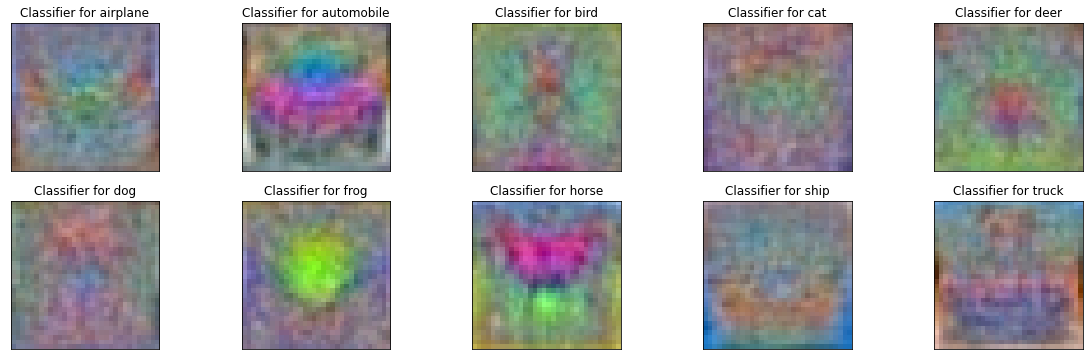

In [48]:
y_hat_test = forward_prop_linear(x_test,weights_linear)
print("Stats for linear classifier")
print("Learning rate:", learning_rate_linear)
print("Training set final mean loss:", linear_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors_linear(y_test, y_hat_test,weights_linear))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

norm_W_linear = (weights_linear[0]-weights_linear[0].min())
norm_W_linear = (255.0*norm_W_linear/norm_W_linear.max()).astype(np.uint8)

fig,ax = plt.subplots(2,5, figsize=(20,6), sharex=True, sharey=True)
for i in range(10):
  weight_image = norm_W_linear[:,i]
  ax[i//5,i%5].set_title("Classifier for " + class_labels[i])
  ax[i//5,i%5].imshow(weight_image.reshape((32,32,3)))
  ax[i//5,i%5].set_xticks([]),ax[i//5,i%5].set_yticks([])
plt.savefig("images/linearClasses.png")
plt.show()

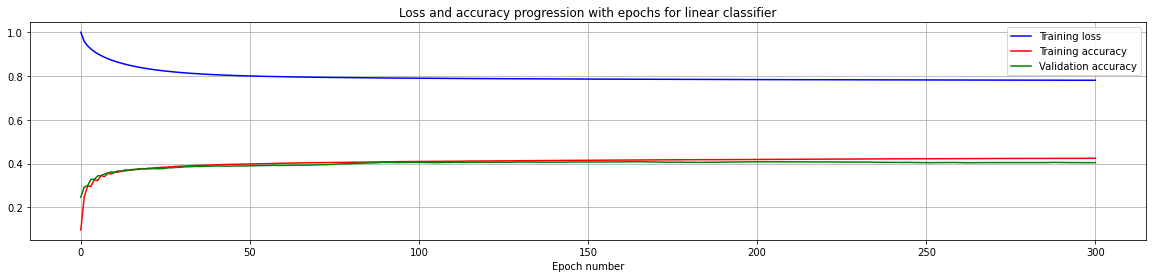

In [49]:
plt.figure(figsize=(20,4))
plt.title("Loss and accuracy progression with epochs for linear classifier")
plt.xlabel("Epoch number")
plt.plot(np.array(linear_loss_history)/max(linear_loss_history), 'b', label="Training loss")
plt.plot(np.array(linear_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(linear_val_acc_history)/100, 'g', label="Validation accuracy")
plt.legend()
plt.grid()
plt.savefig("images/linearLoss.png")
plt.show()

# Part 2: 2-layer neural network

In [9]:
# Activation function
def sigmoid(z):
  return 1/(1+np.exp(-z))

def initialize_2_layer_nn(shape, epsilon=0.001):
  W1 = np.random.randn(shape[0], shape[1])*epsilon
  b1 = np.zeros((1,shape[1]))
  W2 = np.random.randn(shape[1], shape[2])*epsilon
  b2 = np.zeros((1,shape[2]))
  return [W1.astype(np.float64),b1.astype(np.float64),W2.astype(np.float64),
          b2.astype(np.float64)]

def mean_sum_of_squared_errors_2_layer_nn(y, y_hat, weights, reg=0.0):
  """ Loss function """
  diff = (y-y_hat).astype(np.float32)
  return np.mean(np.sum(np.multiply(diff,diff),axis=1)) +\
          reg*np.sum(np.multiply(weights[0],weights[0])) +\
          reg*np.sum(np.multiply(weights[2],weights[2]))

def forward_prop_2_layer_nn(x_data, weights):
  z1 = np.matmul(x_data, weights[0]) + weights[1]
  a1 = sigmoid(z1)
  z2 = np.matmul(a1, weights[2]) + weights[3]
  return [z1,a1,z2]

def back_prop_2_layer_nn(y, xs, weights):
  dz2 = 2*(xs[3]-y)/y.shape[0]
  db2 = np.sum(dz2,axis=0,keepdims=True)
  dW2 = np.matmul(xs[2].T,dz2)
  da1 = np.matmul(dz2,weights[2].T)
  dz1 = xs[2]*(1-xs[2])*da1
  db1 = np.sum(dz1,axis=0,keepdims=True)
  dW1 = np.matmul(xs[0].T, dz1)
  return [dW1,db1,dW2,db2]

def gradient_descent_2_layer_nn(grads, weights, learning_rate=0.01, reg=0.0):
  weights[0] = weights[0]-learning_rate*grads[0]-learning_rate*reg*weights[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  weights[2] = weights[2]-learning_rate*grads[2]-learning_rate*reg*weights[2]
  weights[3] = weights[3]-learning_rate*grads[3]
  return weights

In [10]:
no_epochs = 300
H = 200
weights_nn = initialize_2_layer_nn((x_train.shape[1],H,K))
print("Weight sizes")
for weight in weights_nn:
  print(weight.shape)

nn1_loss_history = []
nn1_train_acc_history = []
nn1_val_acc_history = []
learning_rate_nn1 = 0.015
learning_rate_decay_nn1 = 0.9999
regularization_nn1 = 1e-6

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("\nStarting training of 2-layer Neural Network for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]*100.0
  y_train_shuffled = y_train[ind]

  # Learning step
  results = forward_prop_2_layer_nn(x_train_shuffled,weights_nn)
  y_hat = results[-1]
  loss = mean_sum_of_squared_errors_2_layer_nn(y_train_shuffled, y_hat,\
                                               weights_nn, regularization_nn1)
  grads = back_prop_2_layer_nn(y_train_shuffled, [x_train_shuffled]+results,
                               weights_nn)
  weights = gradient_descent_2_layer_nn(grads, weights_nn, learning_rate_nn1,\
                                        regularization_nn1)
  learning_rate_nn1 *= learning_rate_decay_nn1

  # Maintain history of progression
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  nn1_loss_history.append(loss)
  nn1_train_acc_history.append(train_acc)
  # Validation
  if use_val:
    y_hat_val = forward_prop_2_layer_nn(100.0*x_val, weights_nn)[-1]
    val_acc = get_accuracy(y_hat_val, y_val)
    nn1_val_acc_history.append(val_acc)

  if not(epo%20):
    print("Epoch no", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2),end=" ")
    if use_val: print("\t| Validation accuracy:", np.round(val_acc,2),end="")
    print()

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
(3072, 200)
(1, 200)
(200, 10)
(1, 10)

Starting training of 2-layer Neural Network for 300 epochs
Epoch no 0 	| Training loss: 0.9888778533110425 	| Training accuracy: 10.68 	| Validation accuracy: 22.34
Epoch no 20 	| Training loss: 0.8215567292608087 	| Training accuracy: 33.44 	| Validation accuracy: 33.2
Epoch no 40 	| Training loss: 0.8030378840940273 	| Training accuracy: 36.99 	| Validation accuracy: 36.7
Epoch no 60 	| Training loss: 0.7963441841487421 	| Training accuracy: 37.69 	| Validation accuracy: 36.9
Epoch no 80 	| Training loss: 0.7837696511061105 	| Training accuracy: 39.94 	| Validation accuracy: 39.28
Epoch no 100 	| Training loss: 0.7797401593795845 	| Training accuracy: 40.28 	| Validation accuracy: 40.02
Epoch no 120 	| Training loss: 0.773034003114426 	| Training accuracy: 41.62 	| Validation accuracy: 41.38
Epoch no 140 	| Training loss: 0.7676125069159473 	| Training accuracy: 42.29 	| Validation accuracy: 40.94
Epoch no 160 	| Training loss: 0.7

Stats for neural network classifier
Learning rate: 0.015
Training set final mean loss: 0.7334754788172105
Test set mean loss: 0.7205705046653748
Test set accuracy: 47.27 %



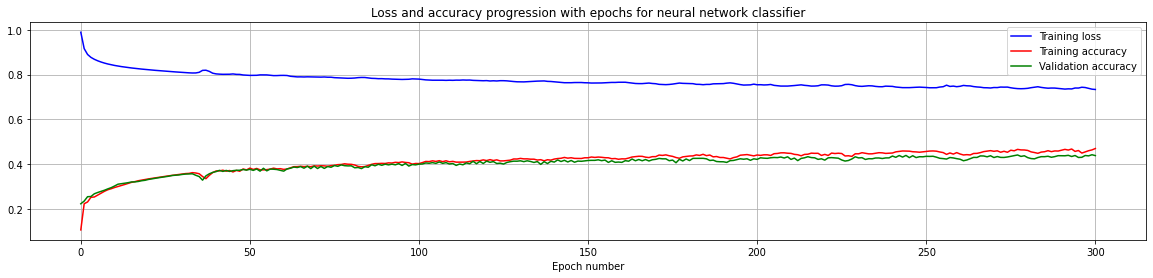

In [63]:
y_hat_test = forward_prop_2_layer_nn(100.0*x_test,weights_nn)[-1]
print("Stats for neural network classifier")
print("Learning rate:", 0.015)
print("Training set final mean loss:", nn1_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors_2_layer_nn(y_test,
                                                      y_hat_test, weights_nn))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

plt.figure(figsize=(20,4))
plt.title("Loss and accuracy progression with epochs for neural network classifier")
plt.xlabel("Epoch number")
plt.plot(nn1_loss_history, 'b', label="Training loss")
plt.plot(np.array(nn1_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(nn1_val_acc_history)/100, 'g',
                     label="Validation accuracy")
plt.legend()
plt.grid()
plt.savefig("images/nn1Loss.png")
plt.show()

# Part 3: Stochastic gradient descent

In [37]:
no_epochs = 300
H = 200
weights_nn = initialize_2_layer_nn((x_train.shape[1],H,K))
print("Weight sizes")
for weight in weights_nn:
  print(weight.shape)
print()

nn2_loss_history = []
nn2_train_acc_history = []
nn2_val_acc_history = []
learning_rate_nn2 = 0.001
learning_rate_decay_nn2 = 0.99
regularization_nn2 = 1e-3
batch_size = 500
steps_per_epoch = int(Ntr/batch_size)

tik = time.time()

seed = 0
rng = np.random.default_rng(seed=seed)

print("Starting training of 2-layer Neural Network with sgd for", no_epochs, "epochs")
for epo in range(no_epochs+1):
  # Shuffle training data
  ind = np.arange(Ntr)
  rng.shuffle(ind)
  x_train_shuffled = x_train[ind]*100.0
  y_train_shuffled = y_train[ind]

  # Learning step down as batches
  for step in range(steps_per_epoch):
    batch = x_train_shuffled[step*batch_size: (step+1)*batch_size]
    batch_labels = y_train_shuffled[step*batch_size: (step+1)*batch_size]
    results = forward_prop_2_layer_nn(batch,weights_nn)
    y_hat = results[-1]
    loss = mean_sum_of_squared_errors_2_layer_nn(batch_labels, y_hat, weights_nn,
                                                 regularization_nn2)
    nn2_loss_history.append(loss)
    grads = back_prop_2_layer_nn(batch_labels, [batch]+results, weights_nn)
    weights = gradient_descent_2_layer_nn(grads, weights_nn, learning_rate_nn2,
                                          regularization_nn2)

  learning_rate_nn2 *= learning_rate_decay_nn2

  # Maintain history of progression
  y_hat = forward_prop_2_layer_nn(x_train_shuffled,weights_nn)[-1]
  train_acc = get_accuracy(y_hat, y_train_shuffled)
  nn2_train_acc_history.append(train_acc)
  # Validation
  y_hat_val = forward_prop_2_layer_nn(x_val*100.0, weights_nn)[-1]
  val_acc = get_accuracy(y_hat_val, y_val)
  nn2_val_acc_history.append(val_acc)

  show_time = True

  if not(epo%20):
    print("Epoch no.", epo, "\t| Training loss:",loss, "\t| Training accuracy:",
          np.round(train_acc,2), "\t| Validation accuracy:", np.round(val_acc,2))

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Weight sizes
(3072, 200)
(1, 200)
(200, 10)
(1, 10)

Starting training of 2-layer Neural Network with sgd for 300 epochs
Epoch no. 0 	| Training loss: 0.8568797626412081 	| Training accuracy: 27.6 	| Validation accuracy: 27.84
Epoch no. 20 	| Training loss: 0.7638854878858578 	| Training accuracy: 42.63 	| Validation accuracy: 41.84
Epoch no. 40 	| Training loss: 0.745811324004408 	| Training accuracy: 46.14 	| Validation accuracy: 44.1
Epoch no. 60 	| Training loss: 0.7318990766912188 	| Training accuracy: 48.32 	| Validation accuracy: 45.34
Epoch no. 80 	| Training loss: 0.706656944149658 	| Training accuracy: 50.04 	| Validation accuracy: 46.12
Epoch no. 100 	| Training loss: 0.70212451708904 	| Training accuracy: 51.57 	| Validation accuracy: 47.06
Epoch no. 120 	| Training loss: 0.7043707605935855 	| Training accuracy: 52.59 	| Validation accuracy: 47.26
Epoch no. 140 	| Training loss: 0.6540471289347405 	| Training accuracy: 53.55 	| Validation accuracy: 47.26
Epoch no. 160 	| Tr

Stats for neural network classifier
Learning rate: 0.015
Training set final mean loss: 0.6714889420765728
Test set mean loss: 0.7205705046653748
Test set accuracy: 47.27 %



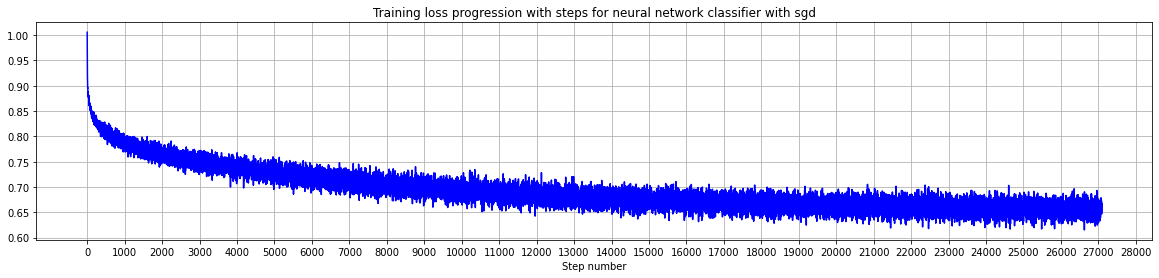

In [62]:
y_hat_test = forward_prop_2_layer_nn(100.0*x_test,weights_nn)[-1]
print("Stats for neural network classifier")
print("Learning rate:", 0.015)
print("Training set final mean loss:", nn2_loss_history[-1])
print("Test set mean loss:",mean_sum_of_squared_errors_2_layer_nn(y_test, y_hat_test, weights_nn))
print("Test set accuracy:", get_accuracy(y_hat_test, y_test),"%\n")

plt.figure(figsize=(20,4))
plt.title("Training loss progression with steps for neural network classifier with sgd")
plt.xlabel("Step number")
plt.xticks(np.arange(0,30001,1000))
plt.plot(nn2_loss_history, 'b', label="Training loss")
plt.grid()
plt.savefig("images/nn2Loss.png")
plt.show()

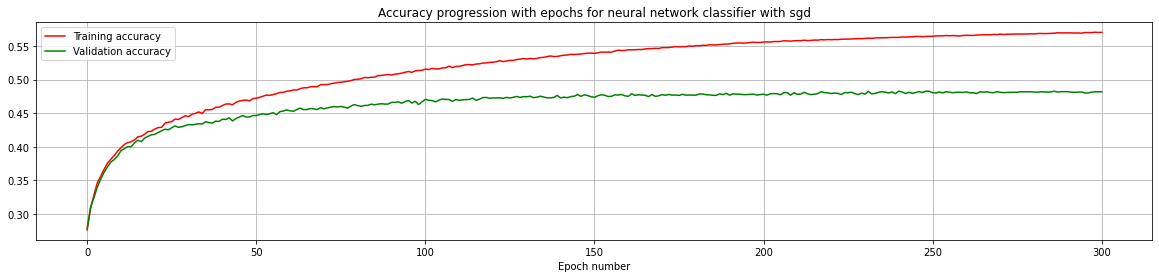

In [52]:
plt.figure(figsize=(20,4))
plt.title("Accuracy progression with epochs for neural network classifier with sgd")
plt.xlabel("Epoch number")
plt.plot(np.array(nn2_train_acc_history)/100, 'r', label="Training accuracy")
if use_val: plt.plot(np.array(nn2_val_acc_history)/100, 'g', label="Validation accuracy")
plt.legend()
plt.grid()
plt.savefig("images/nn2Acc.png")
plt.show()

Comparing part 2 and 3

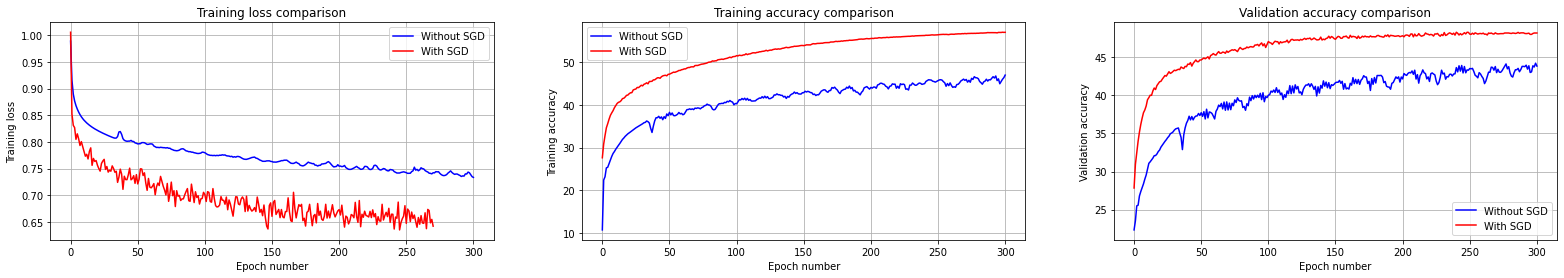

In [61]:
if use_val: fig,ax = plt.subplots(1,3,figsize=(27,4))
else: fig,ax = plt.subplots(1,2,figsize=(20,4))

ax[0].set_title("Training loss comparison")
ax[0].plot(nn1_loss_history, 'b', label="Without SGD")
ax[0].plot(nn2_loss_history[::100], 'r', label="With SGD")
ax[0].set_xlabel("Epoch number")
ax[0].set_ylabel("Training loss")
ax[0].legend()
ax[0].grid()

ax[1].set_title("Training accuracy comparison")
ax[1].plot(nn1_train_acc_history, 'b', label="Without SGD")
ax[1].plot(nn2_train_acc_history, 'r', label="With SGD")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Training accuracy")
ax[1].legend()
ax[1].grid()

if use_val:
  ax[2].set_title("Validation accuracy comparison")
  ax[2].plot(nn1_val_acc_history, 'b', label="Without SGD")
  ax[2].plot(nn2_val_acc_history, 'r', label="With SGD")
  ax[2].set_xlabel("Epoch number")
  ax[2].set_ylabel("Validation accuracy")
  ax[2].legend()
  ax[2].grid()

plt.savefig('images/nn1vs2.png')
plt.show()

# Part 4: CNN

Need to redownload and process the dataset as the CNN uses images in their original form(50000,32,32,3), rather than the flattened form(50000,3072).

In [ ]:
# Download and categorize data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
K = len(np.unique(y_train))

# Compute data parameters
Ntr = x_train.shape[0]
Nte = x_test.shape[0]

# Normalize pixel values
x_train, x_test = x_train/255.0, x_test/255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert labels from integers to binary
y_train = keras.utils.to_categorical(y_train, num_classes=K)
y_test = keras.utils.to_categorical(y_test, num_classes=K)

# Generate train validation splits
train_val_split = 0.9
use_val = False if train_val_split==1.0 else True
if use_val:
  x_train, x_val = x_train[:int(Ntr*train_val_split)], x_train[int(Ntr*train_val_split):]
  y_train, y_val = y_train[:int(Ntr*train_val_split)], y_train[int(Ntr*train_val_split):]
  Ntr,Nv = x_train.shape[0],x_val.shape[0]

class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

print("Training data size :", x_train.shape, "\nTraining label size :",\
      y_train.shape)
if use_val: print("Validation data size:", x_val.shape,\
      "\nValidation label size:", y_val.shape)
print("Test data size :", x_test.shape, "\nTest label size :", y_test.shape)
print("No of classes :", K)

170500096/170498071 [==============================] - 2s 0us/step
Training data size : (45000, 32, 32, 3) 
Training label size : (45000, 10)
Validation data size: (5000, 32, 32, 3) 
Validation label size: (5000, 10)
Test data size : (10000, 32, 32, 3) 
Test label size : (10000, 10)
No of classes : 10


In [ ]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
model = keras.Sequential([
                          keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), name="C32"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(64, (3,3), padding='same', name="C64_1"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(64, (3,3), padding='same', name="C64_2"),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Flatten(),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C32 (Conv2D)                 (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
C64_1 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
C64_2 (Conv2D)               (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [ ]:
learning_rate_cnn = 0.015
learning_rate_decay_cnn = 0.001
sgd = keras.optimizers.SGD(learning_rate_cnn, 0.5, decay=learning_rate_decay_cnn)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tik = time.time()
history = model.fit(x_train, y_train, batch_size=50, epochs=10, validation_data=(x_val, y_val))
tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Epoch 1/10
900/900 [==============================] - 94s 103ms/step - loss: 2.1483 - accuracy: 0.2224 - val_loss: 1.8128 - val_accuracy: 0.3522
Epoch 2/10
900/900 [==============================] - 90s 100ms/step - loss: 1.7600 - accuracy: 0.3820 - val_loss: 1.6191 - val_accuracy: 0.4186
Epoch 3/10
900/900 [==============================] - 90s 100ms/step - loss: 1.5906 - accuracy: 0.4322 - val_loss: 1.5309 - val_accuracy: 0.4446
Epoch 4/10
900/900 [==============================] - 90s 100ms/step - loss: 1.5295 - accuracy: 0.4577 - val_loss: 1.4953 - val_accuracy: 0.4588
Epoch 5/10
900/900 [==============================] - 90s 100ms/step - loss: 1.4777 - accuracy: 0.4747 - val_loss: 1.4600 - val_accuracy: 0.4738
Epoch 6/10
900/900 [==============================] - 93s 104ms/step - loss: 1.4516 - accuracy: 0.4847 - val_loss: 1.4341 - val_accuracy: 0.4846
Epoch 7/10
900/900 [==============================] - 90s 100ms/step - loss: 1.4244 - accuracy: 0.4918 - val_loss: 1.4176 - val_ac

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss:", np.round(loss,5), "Accuracy:", np.round(100*accuracy,2),"%")

1/1 [==============================] - 6s 6s/step - loss: 1.3815 - accuracy: 0.5071
Loss: 1.38154 Accuracy: 50.71 %


Trained the model for 300 epochs in Kaggle using GPU: 15mins elapsed. Faster than running on Colab

Results:
- Final training loss: 1.0047
- Final training accuracy: 65.24%
- Final validation loss: 1.0929
- Final validatio accuracy: 61.44%
- Test set loss: 1.1149
- Test set accuracy: 60.29%

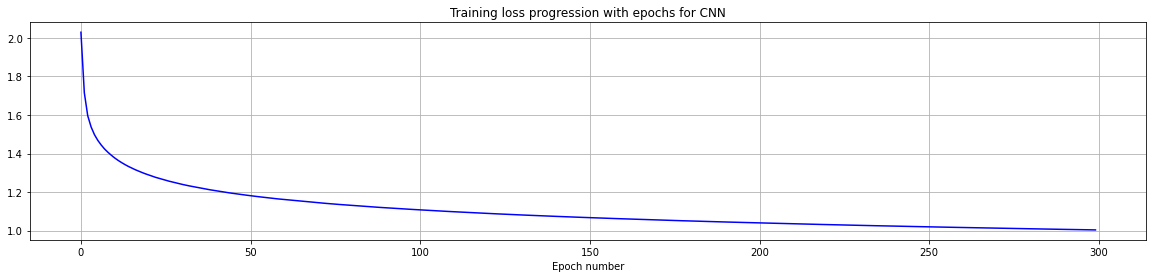

In [57]:
import pandas as pd
kaggle_history = pd.read_csv('history.csv')
cnn_train_loss = kaggle_history['loss']
cnn_train_acc = 100*kaggle_history['accuracy']
cnn_val_acc = 100*kaggle_history['val_accuracy']

plt.figure(figsize=(20,4))
plt.title("Training loss progression with epochs for CNN")
plt.xlabel("Epoch number")
plt.plot(cnn_train_loss, 'b', label="Training loss")
plt.savefig("images/cnnLoss.png")
plt.grid()
plt.show()

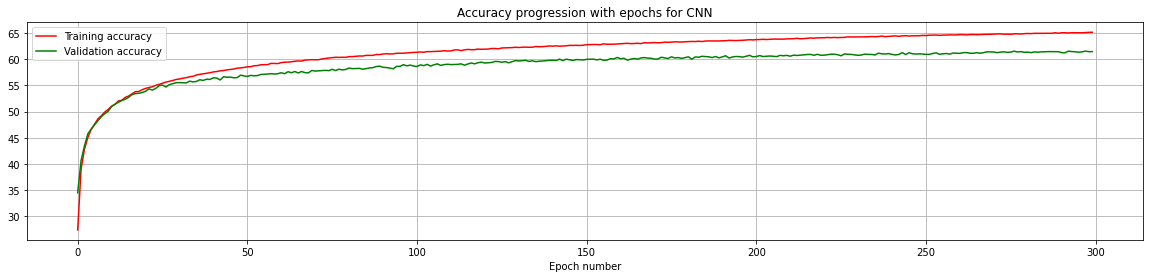

In [58]:
plt.figure(figsize=(20,4))
plt.title("Accuracy progression with epochs for CNN")
plt.xlabel("Epoch number")
plt.plot(cnn_train_acc, 'r', label="Training accuracy")
if use_val: plt.plot(cnn_val_acc, 'g', label="Validation accuracy")
plt.legend()
plt.grid()
plt.savefig("images/cnnAcc.png")
plt.show()

# Overall comparison

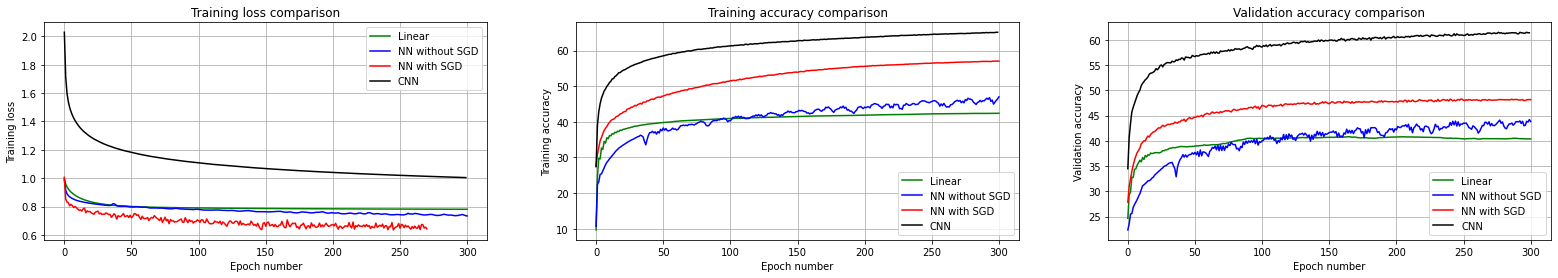

In [64]:
if use_val: fig,ax = plt.subplots(1,3,figsize=(27,4))
else: fig,ax = plt.subplots(1,2,figsize=(20,4))

ax[0].set_title("Training loss comparison")
ax[0].plot(linear_loss_history, 'g', label="Linear")
ax[0].plot(nn1_loss_history, 'b', label="NN without SGD")
ax[0].plot(nn2_loss_history[::100], 'r', label="NN with SGD")
ax[0].plot(cnn_train_loss, 'k', label="CNN")
ax[0].set_xlabel("Epoch number")
ax[0].set_ylabel("Training loss")
ax[0].legend()
ax[0].grid()

ax[1].set_title("Training accuracy comparison")
ax[1].plot(linear_train_acc_history, 'g', label="Linear")
ax[1].plot(nn1_train_acc_history, 'b', label="NN without SGD")
ax[1].plot(nn2_train_acc_history, 'r', label="NN with SGD")
ax[1].plot(cnn_train_acc, 'k', label="CNN")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Training accuracy")
ax[1].legend()
ax[1].grid()

if use_val:
  ax[2].set_title("Validation accuracy comparison")
  ax[2].plot(linear_val_acc_history, 'g', label="Linear")
  ax[2].plot(nn1_val_acc_history, 'b', label="NN without SGD")
  ax[2].plot(nn2_val_acc_history, 'r', label="NN with SGD")
  ax[2].plot(cnn_val_acc, 'k', label="CNN")
  ax[2].set_xlabel("Epoch number")
  ax[2].set_ylabel("Validation accuracy")
  ax[2].legend()
  ax[2].grid()

plt.savefig('images/compareAll.png')
plt.show()